# Generative Adversarial Networks (GANs)

So far in CS231N, all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence generation (which was still phrased as a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $x \sim p_\text{data}$ are samples from the input data, $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

Example pictures of what you should expect (yours might look slightly different):

![caption](gan_outputs_tf.png)


## Setup

In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

answers = np.load('gan-checks-tf.npz')


## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable without a GPU, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 

To simplify our code here, we will use the TensorFlow MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/learn/python/learn/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`. 

**Heads-up**: The TensorFlow MNIST wrapper returns images as vectors. That is, they're size (batch, 784). If you want to treat them as images, we have to resize them to (batch,28,28) or (batch,28,28,1). They are also type np.float32 and bounded [0,1]. 

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./cs231n/datasets/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./cs231n/datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


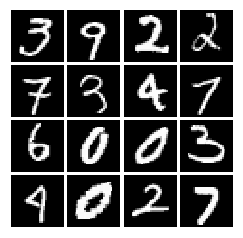

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0])

## LeakyReLU
In the cell below, you should implement a LeakyReLU. See the [class notes](http://cs231n.github.io/neural-networks-1/) (where alpha is small number) or equation (3) in [this paper](http://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf). LeakyReLUs keep ReLU units from dying and are often used in GAN methods (as are maxout units, however those increase model size and therefore are not used in this notebook).

HINT: You should be able to use `tf.maximum`

In [3]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    return tf.maximum(x, alpha*x)
    # tf.maximum(x, 0) - alpha * tf.maximum(-x, 0)


Test your leaky ReLU implementation. You should get errors < 1e-10

In [4]:
def test_leaky_relu(x, y_true):
    tf.reset_default_graph()
    with get_session() as sess:
        y_tf = leaky_relu(tf.constant(x))
        y = sess.run(y_tf)
        print('Maximum error: %g'%rel_error(y_true, y))

test_leaky_relu(answers['lrelu_x'], answers['lrelu_y'])

Maximum error: 0


## Random Noise
Generate a TensorFlow `Tensor` containing uniform noise from -1 to 1 with shape `[batch_size, dim]`.

In [5]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    
    return tf.random_uniform([batch_size, dim], -1., 1.)


Make sure noise is the correct shape and type:

In [6]:
def test_sample_noise():
    batch_size = 3
    dim = 4
    tf.reset_default_graph()
    with get_session() as sess:
        z = sample_noise(batch_size, dim)
        # Check z has the correct shape
        assert z.get_shape().as_list() == [batch_size, dim]
        # Make sure z is a Tensor and not a numpy array
        assert isinstance(z, tf.Tensor)
        # Check that we get different noise for different evaluations
        z1 = sess.run(z)
        z2 = sess.run(z)
        assert not np.array_equal(z1, z2)
        # Check that we get the correct range
        assert np.all(z1 >= -1.0) and np.all(z1 <= 1.0)
        print("All tests passed!")
    
test_sample_noise()

All tests passed!


## Discriminator
Our first step is to build a discriminator. You should use the layers in `tf.layers` to build the model.
All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from size 784 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 256
 * LeakyReLU with alpha 0.01
 * Fully connected layer from 256 to 1
 
The output of the discriminator should have shape `[batch_size, 1]`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

In [7]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        z1 = tf.layers.dense(inputs=x, units=256)
        a1 = leaky_relu(z1, 0.01)
        z2 = tf.layers.dense(inputs=a1, units=256)
        a2 = leaky_relu(z2, 0.01)
        logits = tf.layers.dense(inputs=a2, units=1)
        return logits

Test to make sure the number of parameters in the discriminator is correct:

In [8]:
def test_discriminator(true_count=267009):
    tf.reset_default_graph()
    with get_session() as sess:
        y = discriminator(tf.ones((2, 784)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in discriminator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in discriminator.')
        
test_discriminator()

Correct number of parameters in discriminator.


## Generator
Now to build a generator. You should use the layers in `tf.layers` to construct the model. All fully connected layers should include bias terms.

Architecture:
 * Fully connected layer from tf.shape(z)[1] (the number of noise dimensions) to 1024
 * ReLU
 * Fully connected layer from 1024 to 1024 
 * ReLU
 * Fully connected layer from 1024 to 784
 * TanH (To restrict the output to be [-1,1])

In [9]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        a1 = tf.layers.dense(inputs=z, units=1024, activation=tf.nn.relu)
        a2 = tf.layers.dense(inputs=a1, units=1024, activation=tf.nn.relu)
        img = tf.layers.dense(inputs=a2, units=784, activation=tf.tanh)
        return img

Test to make sure the number of parameters in the generator is correct:

In [10]:
def test_generator(true_count=1858320):
    tf.reset_default_graph()
    with get_session() as sess:
        y = generator(tf.ones((1, 4)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in generator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in generator.')
        
test_generator()

Correct number of parameters in generator.


# GAN Loss

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: Use [tf.ones_like](https://www.tensorflow.org/api_docs/python/tf/ones_like) and [tf.zeros_like](https://www.tensorflow.org/api_docs/python/tf/zeros_like) to generate labels for your discriminator. Use [sigmoid_cross_entropy loss](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) to help compute your loss function. Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [11]:
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        score that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        score that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_real),logits=logits_real) + \
                            tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(logits_fake),logits=logits_fake))
    G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_fake),logits=logits_fake))
    return D_loss, G_loss

Test your GAN loss. Make sure both the generator and discriminator loss are correct. You should see errors less than 1e-5.

In [12]:
def test_gan_loss(logits_real, logits_fake, d_loss_true, g_loss_true):
    tf.reset_default_graph()
    with get_session() as sess:
        d_loss, g_loss = sess.run(gan_loss(tf.constant(logits_real), tf.constant(logits_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_gan_loss(answers['logits_real'], answers['logits_fake'],
              answers['d_loss_true'], answers['g_loss_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


# Optimizing our loss
Make an `AdamOptimizer` with a 1e-3 learning rate, beta1=0.5 to mininize G_loss and D_loss separately. The trick of decreasing beta was shown to be effective in helping GANs converge in the [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498) paper. In fact, with our current hyperparameters, if you set beta1 to the Tensorflow default of 0.9, there's a good chance your discriminator loss will go to zero and the generator will fail to learn entirely. In fact, this is a common failure mode in GANs; if your D(x) learns to be too fast (e.g. loss goes near zero), your G(z) is never able to learn. Often D(x) is trained with SGD with Momentum or RMSProp instead of Adam, but here we'll use Adam for both D(x) and G(z). 

In [13]:
# TODO: create an AdamOptimizer for D_solver and G_solver
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    pass
    return D_solver, G_solver

## Putting it all together
Now just a bit of Lego Construction.. Read this section over carefully to understand how we'll be composing the generator and discriminator

In [14]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    # Re-use 설정 안해주면 변수를 새로 initialize해서 쓰라는건지, 기존에 initialize된걸 쓰라는건지 몰라서 value error
    # 변수공유 관련 자세한 내용은 https://tensorflowkorea.gitbooks.io/tensorflow-kr/content/g3doc/how_tos/variable_scope/ 참고
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

# Training a GAN!
Well that wasn't so hard, was it? In the iterations in the low 100s you should see black backgrounds, fuzzy shapes as you approach iteration 1000, and decent shapes, about half of which will be sharp and clearly recognizable as we pass 3000. In our case, we'll simply train D(x) and G(z) with one batch each every iteration. However, papers often experiment with different schedules of training D(x) and G(z), sometimes doing one for more steps than the other, or even training each one until the loss gets "good enough" and then switching to training the other. 

In [15]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

#### Train your GAN! This should take about 10 minutes on a CPU, or less than a minute on GPU.

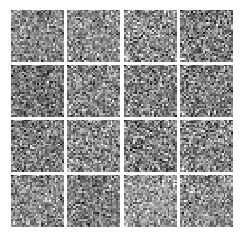


Iter: 0, D: 1.283, G:0.6475
Iter: 50, D: 1.556, G:1.729
Iter: 100, D: 1.679, G:0.6133
Iter: 150, D: 1.439, G:0.9544
Iter: 200, D: 2.336, G:0.5351


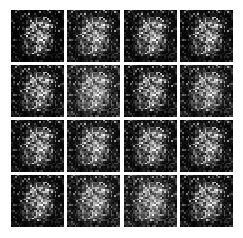


Iter: 250, D: 1.195, G:0.9978
Iter: 300, D: 2.157, G:0.838
Iter: 350, D: 1.021, G:1.367
Iter: 400, D: 1.206, G:1.7
Iter: 450, D: 1.64, G:0.3778


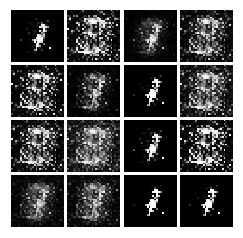


Iter: 500, D: 1.089, G:1.011
Iter: 550, D: 0.9827, G:1.64
Iter: 600, D: 1.1, G:1.641
Iter: 650, D: 1.314, G:1.069
Iter: 700, D: 1.118, G:1.871


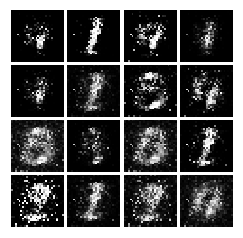


Iter: 750, D: 1.133, G:1.129
Iter: 800, D: 1.113, G:1.063
Iter: 850, D: 1.249, G:0.9353
Iter: 900, D: 1.09, G:1.066
Iter: 950, D: 1.322, G:1.148


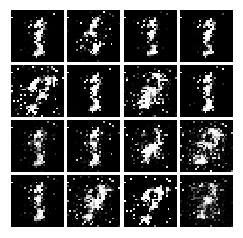


Iter: 1000, D: 1.098, G:1.126
Iter: 1050, D: 0.9614, G:2.251
Iter: 1100, D: 1.033, G:1.381
Iter: 1150, D: 1.18, G:1.391
Iter: 1200, D: 1.137, G:1.6


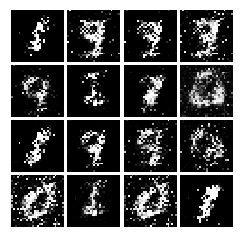


Iter: 1250, D: 1.267, G:2.033
Iter: 1300, D: 1.005, G:1.222
Iter: 1350, D: 1.07, G:1.327
Iter: 1400, D: 1.669, G:0.313
Iter: 1450, D: 1.334, G:0.9539


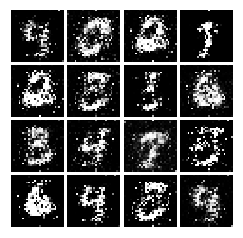


Iter: 1500, D: 1.413, G:1.316
Iter: 1550, D: 1.298, G:1.779
Iter: 1600, D: 1.365, G:0.8148
Iter: 1650, D: 1.304, G:0.9713
Iter: 1700, D: 1.275, G:0.9646


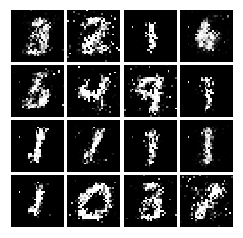


Iter: 1750, D: 1.188, G:0.8752
Iter: 1800, D: 1.32, G:0.9886
Iter: 1850, D: 1.345, G:1.163
Iter: 1900, D: 1.3, G:0.8687
Iter: 1950, D: 1.326, G:0.7993


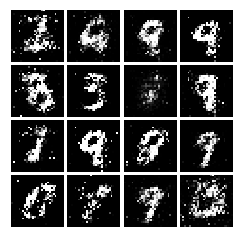


Iter: 2000, D: 1.134, G:0.6777
Iter: 2050, D: 1.244, G:1.038
Iter: 2100, D: 1.308, G:0.8862
Iter: 2150, D: 1.267, G:0.9187
Iter: 2200, D: 1.243, G:1.094


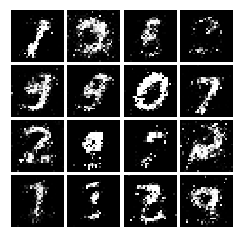


Iter: 2250, D: 1.233, G:0.8665
Iter: 2300, D: 1.302, G:0.8677
Iter: 2350, D: 1.294, G:0.7843
Iter: 2400, D: 1.388, G:0.8195
Iter: 2450, D: 1.325, G:0.8048


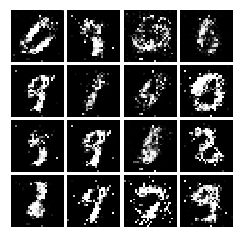


Iter: 2500, D: 1.364, G:1.17
Iter: 2550, D: 1.315, G:0.7743
Iter: 2600, D: 1.315, G:0.8371
Iter: 2650, D: 1.343, G:0.9066
Iter: 2700, D: 1.321, G:0.8349


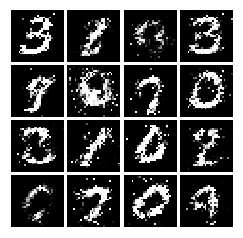


Iter: 2750, D: 1.281, G:0.7941
Iter: 2800, D: 1.349, G:0.8111
Iter: 2850, D: 1.348, G:0.8551
Iter: 2900, D: 1.387, G:0.9412
Iter: 2950, D: 1.354, G:0.9029


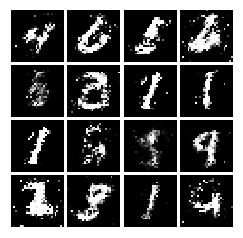


Iter: 3000, D: 1.367, G:0.8983
Iter: 3050, D: 1.375, G:0.8467
Iter: 3100, D: 1.39, G:0.9053
Iter: 3150, D: 1.363, G:0.7773
Iter: 3200, D: 1.341, G:0.8665


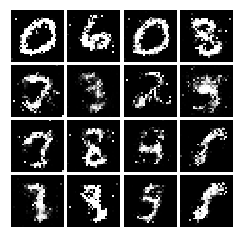


Iter: 3250, D: 1.323, G:0.7487
Iter: 3300, D: 1.362, G:0.803
Iter: 3350, D: 1.383, G:0.8422
Iter: 3400, D: 1.292, G:0.8171
Iter: 3450, D: 1.386, G:0.8191


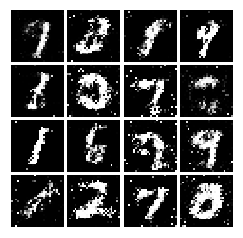


Iter: 3500, D: 1.316, G:0.7521
Iter: 3550, D: 1.36, G:0.8218
Iter: 3600, D: 1.385, G:0.7653
Iter: 3650, D: 1.328, G:0.8464
Iter: 3700, D: 1.309, G:0.848


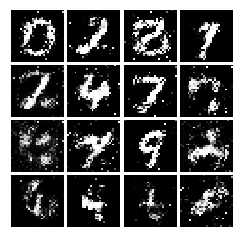


Iter: 3750, D: 1.327, G:0.8401
Iter: 3800, D: 1.359, G:0.8239
Iter: 3850, D: 1.344, G:0.7943
Iter: 3900, D: 1.314, G:0.8721
Iter: 3950, D: 1.3, G:0.8816


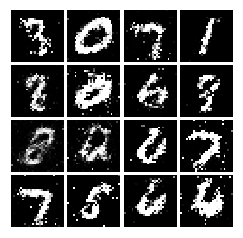


Iter: 4000, D: 1.367, G:0.9182
Iter: 4050, D: 1.316, G:0.7668
Iter: 4100, D: 1.253, G:0.8468
Iter: 4150, D: 1.293, G:0.8687
Iter: 4200, D: 1.28, G:0.796


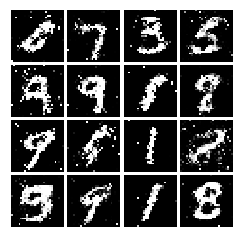


Iter: 4250, D: 1.332, G:0.8272
Final images


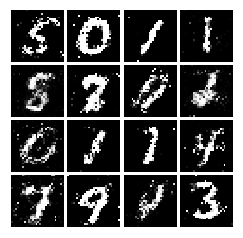

In [30]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

# Least Squares GAN
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alternative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$


**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`score_real` and `score_fake`).

In [31]:
def lsgan_loss(score_real, score_fake):
    """Compute the Least Squares GAN loss.
    
    Inputs:
    - score_real: Tensor, shape [batch_size, 1], output of discriminator
        score for each real image
    - score_fake: Tensor, shape[batch_size, 1], output of discriminator
        score for each fake image    
          
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = 1/2 * tf.reduce_mean((score_real - 1)**2) + 1/2 * tf.reduce_mean((score_fake)**2)
    G_loss = 1/2 * tf.reduce_mean((score_fake - 1)**2)
    pass
    return D_loss, G_loss

Test your LSGAN loss. You should see errors less than 1e-7.

In [32]:
def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    with get_session() as sess:
        d_loss, g_loss = sess.run(
            lsgan_loss(tf.constant(score_real), tf.constant(score_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(answers['logits_real'], answers['logits_fake'],
                answers['d_loss_lsgan_true'], answers['g_loss_lsgan_true'])

Maximum error in d_loss: 0
Maximum error in g_loss: 0


Create new training steps so we instead minimize the LSGAN loss:

In [33]:
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

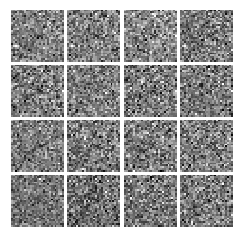


Iter: 0, D: 0.1756, G:0.3863
Iter: 50, D: 0.0224, G:0.8034
Iter: 100, D: 0.03952, G:0.568
Iter: 150, D: 0.1345, G:0.5532
Iter: 200, D: 0.2226, G:0.3523


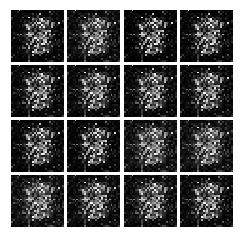


Iter: 250, D: 0.17, G:0.4416
Iter: 300, D: 0.2061, G:0.5032
Iter: 350, D: 0.1029, G:0.3901
Iter: 400, D: 0.05076, G:0.6456
Iter: 450, D: 0.04856, G:1.173


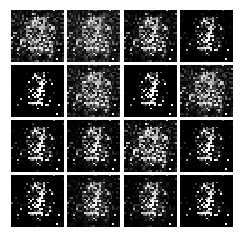


Iter: 500, D: 0.2141, G:2.276
Iter: 550, D: 0.1825, G:0.4529
Iter: 600, D: 0.1552, G:0.4945
Iter: 650, D: 0.1202, G:0.248
Iter: 700, D: 0.1299, G:0.4698


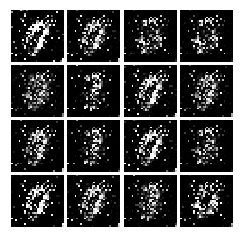


Iter: 750, D: 0.1004, G:0.5322
Iter: 800, D: 0.1266, G:1.146
Iter: 850, D: 0.2224, G:0.389
Iter: 900, D: 0.06183, G:0.4751
Iter: 950, D: 0.07627, G:0.4719


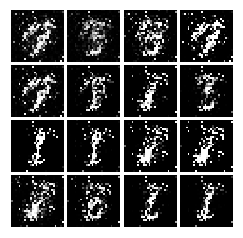


Iter: 1000, D: 0.1322, G:0.2764
Iter: 1050, D: 0.1399, G:0.3383
Iter: 1100, D: 0.148, G:0.3026
Iter: 1150, D: 0.1647, G:0.9516
Iter: 1200, D: 0.1311, G:0.2958


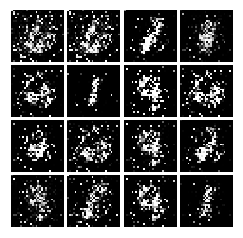


Iter: 1250, D: 0.1599, G:0.4137
Iter: 1300, D: 0.1182, G:0.3394
Iter: 1350, D: 0.1443, G:0.3125
Iter: 1400, D: 0.1667, G:0.2619
Iter: 1450, D: 0.2089, G:0.2333


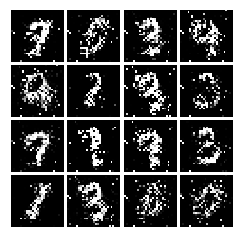


Iter: 1500, D: 0.1571, G:0.1775
Iter: 1550, D: 0.1284, G:0.2738
Iter: 1600, D: 0.1285, G:0.3246
Iter: 1650, D: 0.1775, G:0.2781
Iter: 1700, D: 0.1671, G:0.1632


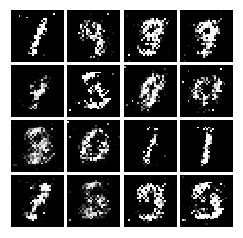


Iter: 1750, D: 0.2059, G:0.2464
Iter: 1800, D: 0.2227, G:0.2086
Iter: 1850, D: 0.1978, G:0.2318
Iter: 1900, D: 0.2061, G:0.1791
Iter: 1950, D: 0.2113, G:0.2607


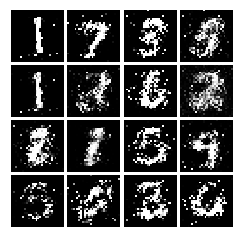


Iter: 2000, D: 0.2019, G:0.2212
Iter: 2050, D: 0.2251, G:0.1935
Iter: 2100, D: 0.246, G:0.2195
Iter: 2150, D: 0.2055, G:0.1767
Iter: 2200, D: 0.2021, G:0.1688


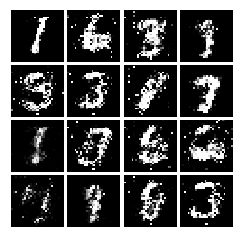


Iter: 2250, D: 0.2178, G:0.186
Iter: 2300, D: 0.2328, G:0.1667
Iter: 2350, D: 0.2071, G:0.1832
Iter: 2400, D: 0.2227, G:0.1768
Iter: 2450, D: 0.2299, G:0.1946


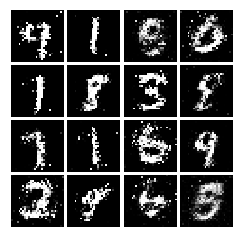


Iter: 2500, D: 0.2401, G:0.1769
Iter: 2550, D: 0.2617, G:0.1432
Iter: 2600, D: 0.217, G:0.1534
Iter: 2650, D: 0.2321, G:0.1606
Iter: 2700, D: 0.2249, G:0.1612


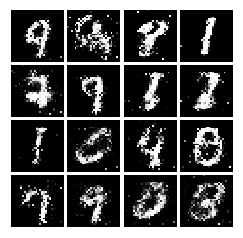


Iter: 2750, D: 0.2359, G:0.1747
Iter: 2800, D: 0.2246, G:0.2042
Iter: 2850, D: 0.2465, G:0.1979
Iter: 2900, D: 0.2087, G:0.1539
Iter: 2950, D: 0.2336, G:0.1754


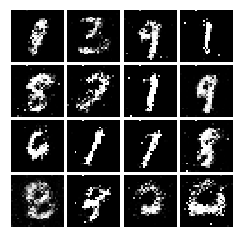


Iter: 3000, D: 0.2384, G:0.1598
Iter: 3050, D: 0.2386, G:0.1725
Iter: 3100, D: 0.2203, G:0.1731
Iter: 3150, D: 0.2188, G:0.166
Iter: 3200, D: 0.2269, G:0.1698


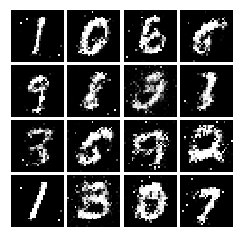


Iter: 3250, D: 0.227, G:0.1604
Iter: 3300, D: 0.2269, G:0.166
Iter: 3350, D: 0.2411, G:0.17
Iter: 3400, D: 0.2157, G:0.1719
Iter: 3450, D: 0.2199, G:0.1945


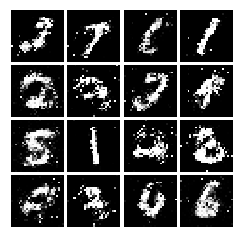


Iter: 3500, D: 0.2345, G:0.2164
Iter: 3550, D: 0.2268, G:0.1545
Iter: 3600, D: 0.2393, G:0.171
Iter: 3650, D: 0.2172, G:0.1722
Iter: 3700, D: 0.2263, G:0.1691


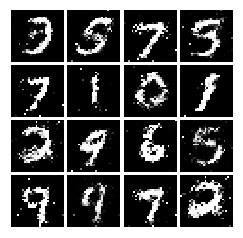


Iter: 3750, D: 0.233, G:0.1593
Iter: 3800, D: 0.2211, G:0.1721
Iter: 3850, D: 0.2331, G:0.1723
Iter: 3900, D: 0.2316, G:0.1871
Iter: 3950, D: 0.2439, G:0.1705


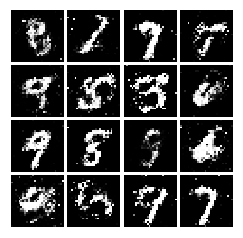


Iter: 4000, D: 0.224, G:0.1573
Iter: 4050, D: 0.22, G:0.1617
Iter: 4100, D: 0.216, G:0.1796
Iter: 4150, D: 0.2258, G:0.1535
Iter: 4200, D: 0.2466, G:0.1482


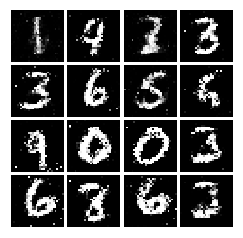


Iter: 4250, D: 0.2132, G:0.1841
Final images


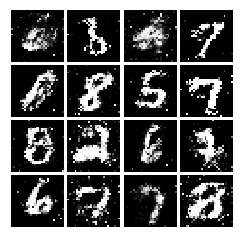

In [34]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step)

# INLINE QUESTION 1:
Describe how the visual quality of the samples changes over the course of training. Do you notice anything about the distribution of the samples? How do the results change across different training runs?

** 이미지의 중심부에 형체가 잡히지 않은 무언가가 나타나다가 점점 형체, 경계가 뚜렷해짐 **

# Deep Convolutional GANs
In the first part of the notebook, we implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, we will implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where we use convolutional networks as our discriminators and generators.

#### Discriminator
We will use a discriminator inspired by the TensorFlow MNIST classification [tutorial](https://www.tensorflow.org/get_started/mnist/pros), which is able to get above 99% accuracy on the MNIST dataset fairly quickly. *Be sure to check the dimensions of x and reshape when needed*, fully connected blocks expect [N,D] Tensors while conv2d blocks expect [N,H,W,C] Tensors. 

Architecture:
* 32 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* 64 Filters, 5x5, Stride 1, Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected size 4 x 4 x 64, Leaky ReLU(alpha=0.01)
* Fully Connected size 1

In [16]:
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        x_reshaped = tf.reshape(x, shape=[-1, 28, 28, 1])
        conv1 = tf.layers.conv2d(x_reshaped, 32, 5, activation=leaky_relu)
        pool1 = tf.layers.max_pooling2d(conv1, 2, 2)
        conv2 = tf.layers.conv2d(pool1, 64, 5, activation=leaky_relu)
        pool2 = tf.layers.max_pooling2d(conv2, 2, 2)
        flat = tf.layers.flatten(pool2)
        dense1 = tf.layers.dense(flat, 4*4*64, activation=leaky_relu)
        logits = tf.layers.dense(dense1, 1)
        return logits
test_discriminator(1102721)

Correct number of parameters in discriminator.


#### Generator
For the generator, we will copy the architecture exactly from the [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf). See Appendix C.1 MNIST. See the documentation for [tf.nn.conv2d_transpose](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). We are always "training" in GAN mode.

Architecture:
* Fully connected of size 1024, ReLU
* BatchNorm
* Fully connected of size 7 x 7 x 128, ReLU
* BatchNorm
* Resize into Image Tensor
* 64 conv2d^T (transpose) filters of 4x4, stride 2, ReLU
* BatchNorm
* 1 conv2d^T (transpose) filter of 4x4, stride 2, TanH

In [17]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        dense1 = tf.layers.dense(z, 1024, activation=tf.nn.relu)
        bn1 = tf.layers.batch_normalization(dense1, training=True)
        dense2 = tf.layers.dense(bn1, 7*7*128, activation=tf.nn.relu)
        bn2 = tf.layers.batch_normalization(dense2, training=True)
        img_reshaped = tf.reshape(bn2, [-1, 7, 7, 128])
        trans_conv1 = tf.layers.conv2d_transpose(img_reshaped, 64, 4, 2, activation=tf.nn.relu, padding='same')
        bn3 = tf.layers.batch_normalization(trans_conv1, training=True)
        trans_conv2 = tf.layers.conv2d_transpose(bn3, 1, 4, 2, activation=tf.nn.tanh, padding='same')
        img = tf.reshape(trans_conv2, [-1, 784])
        return img
test_generator(6595521)

Correct number of parameters in generator.


We have to recreate our network since we've changed our functions.

In [18]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = gan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

### Train and evaluate a DCGAN
This is the one part of A3 that significantly benefits from using a GPU. It takes 3 minutes on a GPU for the requested five epochs. Or about 50 minutes on a dual core laptop on CPU (feel free to use 3 epochs if you do it on CPU).

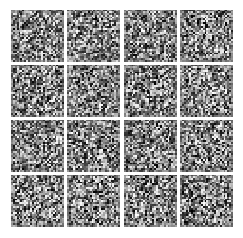


Iter: 0, D: 1.359, G:0.7227
Iter: 50, D: 0.789, G:0.919
Iter: 100, D: 0.7527, G:1.235
Iter: 150, D: 0.8721, G:0.7127
Iter: 200, D: 1.0, G:1.222


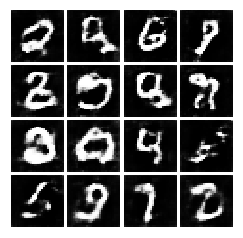


Iter: 250, D: 1.14, G:1.812
Iter: 300, D: 1.303, G:0.2673
Iter: 350, D: 1.12, G:0.9292
Iter: 400, D: 1.121, G:1.245
Iter: 450, D: 1.146, G:1.033


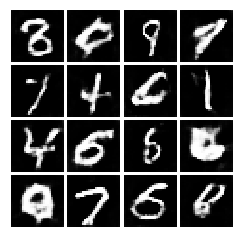


Iter: 500, D: 1.137, G:0.6812
Iter: 550, D: 1.11, G:0.9219
Iter: 600, D: 1.188, G:1.051
Iter: 650, D: 1.101, G:1.07
Iter: 700, D: 1.167, G:0.9193


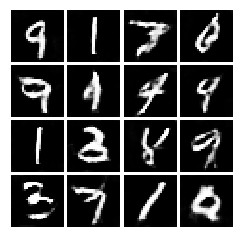


Iter: 750, D: 1.176, G:1.031
Iter: 800, D: 1.082, G:0.9381
Iter: 850, D: 1.245, G:0.8254
Iter: 900, D: 1.155, G:0.9512
Iter: 950, D: 1.321, G:0.6109


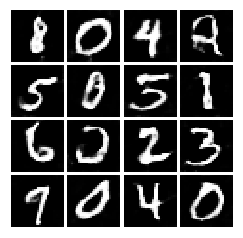


Iter: 1000, D: 1.197, G:1.062
Iter: 1050, D: 1.256, G:0.5293
Iter: 1100, D: 1.149, G:1.101
Iter: 1150, D: 1.171, G:0.9445
Iter: 1200, D: 1.265, G:1.589


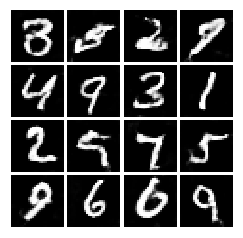


Iter: 1250, D: 1.138, G:0.9364
Final images


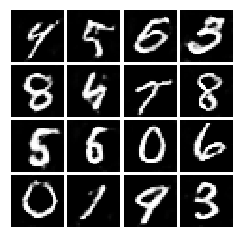

In [19]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,num_epoch=3)

# INLINE QUESTION 2:
What differences do you see between the DCGAN results and the original GAN results?

answer: 이미지의 경계가 훨씬 선명하고 뚜렷함

------

# Extra Credit 
** Be sure you don't destroy your results above, but feel free to copy+paste code to get results below **
* For a small amount of extra credit, you can implement additional new GAN loss functions below, provided they converge. See AFI, BiGAN, Softmax GAN, Conditional GAN, InfoGAN, etc. They should converge to get credit.
* Likewise for an improved architecture or using a convolutional GAN (or even implement a VAE)
* For a bigger chunk of extra credit, load the CIFAR10 data (see last assignment) and train a compelling generative model on CIFAR-10
* Demonstrate the value of GANs in building semi-supervised models. In a semi-supervised example, only some fraction of the input data has labels; we can supervise this in MNIST by only training on a few dozen or hundred labeled examples. This was first described in [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498).
* Something new/cool.

#### Describe what you did: Conditional GAN

In [16]:
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=True)

Extracting ./cs231n/datasets/MNIST_data\train-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./cs231n/datasets/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data\t10k-labels-idx1-ubyte.gz


In [21]:
def discriminator(x, y):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    - y: TensorFlow Tensor(one-hot) of conditional vector(in this case, image label), shape [batch_size, 10]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        z1 = tf.layers.dense(inputs=tf.concat([x,y], axis=1), units=256)
        a1 = leaky_relu(z1, 0.01)
        z2 = tf.layers.dense(inputs=a1, units=256)
        a2 = leaky_relu(z2, 0.01)
        logits = tf.layers.dense(inputs=a2, units=1)
        return logits

def generator(z, y):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    - y: TensorFlow Tensor of conditional vector, shape [batch_size, 10]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        
        a1 = tf.layers.dense(inputs=tf.concat([z,y], axis=1), units=1024, activation=tf.nn.relu)
        a2 = tf.layers.dense(inputs=a1, units=1024, activation=tf.nn.relu)
        img = tf.layers.dense(inputs=a2, units=784, activation=tf.tanh)
        tf.get_variable_scope().reuse_variables()
        return img
    
    
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, [None, 10])
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)


# generated images


# sample for printing results every show_every iterations
with tf.variable_scope("0") as scope0:
    G_sample = generator(z, y)
    scope0.reuse_variables()
    sample = sample_noise(10, noise_dim)
    sample_img = generator(sample, y)

with tf.variable_scope("1") as scope1:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x), y)
    # Re-use discriminator weights on new inputs
    # Re-use 설정 안해주면 변수를 새로 initialize해서 쓰라는건지, 기존에 initialize된걸 쓰라는건지 몰라서 value error
    # 변수공유 관련 자세한 내용은 https://tensorflowkorea.gitbooks.io/tensorflow-kr/content/g3doc/how_tos/variable_scope/ 참고
    scope1.reuse_variables()
    logits_fake = discriminator(G_sample, y)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, '1/discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, '0/generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

saver = tf.train.Saver()

# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(sample_img, feed_dict={y:sess.run(tf.one_hot([0,1,2,3,4,5,6,7,8,9], 10))})
            fig = show_images(samples)
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minibatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch, y:minibatch_y})
        _, G_loss_curr = sess.run([G_train_step, G_loss], feed_dict={y:minibatch_y})

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(sample_img, feed_dict={y:sess.run(tf.one_hot([0,1,2,3,4,5,6,7,8,9], 10))})

    fig = show_images(samples)
    plt.show()
    
    path=saver.save(sess, 'C:/Users/공관/ml/assignment3/tmp/my_model.ckpt',global_step=max_iter)
    return path

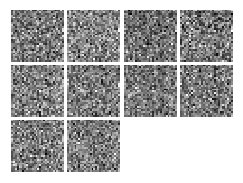


Iter: 0, D: 1.244, G:0.6723
Iter: 50, D: 0.2523, G:2.633
Iter: 100, D: 1.914, G:0.7434
Iter: 150, D: 1.444, G:0.95
Iter: 200, D: 1.256, G:1.197


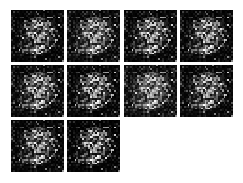


Iter: 250, D: 1.171, G:1.19
Iter: 300, D: 0.9748, G:1.726
Iter: 350, D: 1.825, G:0.4722
Iter: 400, D: 1.097, G:0.9783
Iter: 450, D: 0.9399, G:1.326


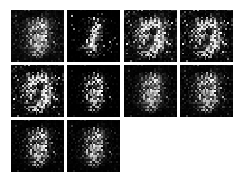


Iter: 500, D: 1.265, G:2.018
Iter: 550, D: 0.9088, G:1.382
Iter: 600, D: 1.057, G:1.627
Iter: 650, D: 1.309, G:1.837
Iter: 700, D: 1.217, G:1.336


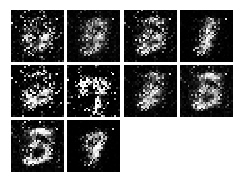


Iter: 750, D: 0.9908, G:1.328
Iter: 800, D: 1.249, G:1.013
Iter: 850, D: 1.176, G:3.203
Iter: 900, D: 1.289, G:1.444
Iter: 950, D: 1.265, G:1.204


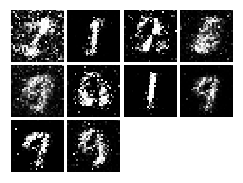


Iter: 1000, D: 1.199, G:0.8829
Iter: 1050, D: 1.079, G:1.004
Iter: 1100, D: 1.407, G:0.8212
Iter: 1150, D: 1.264, G:2.464
Iter: 1200, D: 1.288, G:0.9863


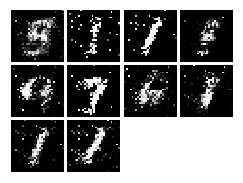


Iter: 1250, D: 1.131, G:1.123
Iter: 1300, D: 1.173, G:1.194
Iter: 1350, D: 1.176, G:1.487
Iter: 1400, D: 1.157, G:0.9135
Iter: 1450, D: 1.275, G:1.064


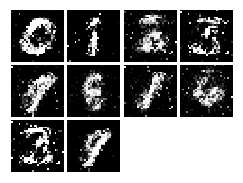


Iter: 1500, D: 1.226, G:1.146
Iter: 1550, D: 1.312, G:0.8978
Iter: 1600, D: 1.203, G:1.224
Iter: 1650, D: 1.233, G:1.105
Iter: 1700, D: 1.327, G:0.9781


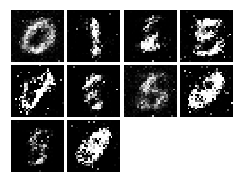


Iter: 1750, D: 1.216, G:0.6736
Iter: 1800, D: 1.338, G:0.8607
Iter: 1850, D: 1.346, G:1.287
Iter: 1900, D: 1.197, G:0.9
Iter: 1950, D: 1.203, G:0.8647


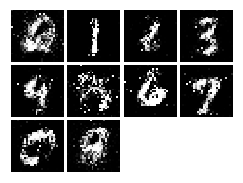


Iter: 2000, D: 1.302, G:1.067
Iter: 2050, D: 1.361, G:0.9629
Iter: 2100, D: 1.314, G:0.8749
Iter: 2150, D: 1.246, G:0.8962
Iter: 2200, D: 1.282, G:0.9008


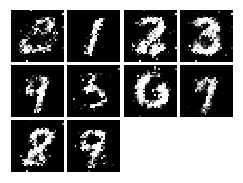


Iter: 2250, D: 1.296, G:0.8331
Iter: 2300, D: 1.335, G:0.8204
Iter: 2350, D: 1.287, G:1.043
Iter: 2400, D: 1.32, G:0.8485
Iter: 2450, D: 1.36, G:0.8485


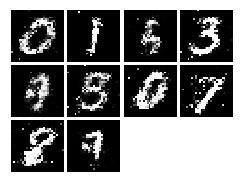


Iter: 2500, D: 1.297, G:0.8913
Iter: 2550, D: 1.276, G:0.8422
Iter: 2600, D: 1.382, G:0.9338
Iter: 2650, D: 1.299, G:0.818
Iter: 2700, D: 1.377, G:0.8224


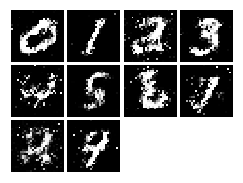


Iter: 2750, D: 1.318, G:0.9188
Iter: 2800, D: 1.326, G:0.9139
Iter: 2850, D: 1.358, G:0.7884
Iter: 2900, D: 1.325, G:0.7771
Iter: 2950, D: 1.366, G:0.7549


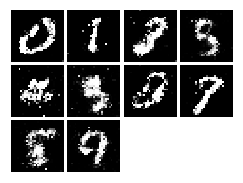


Iter: 3000, D: 1.299, G:0.7945
Iter: 3050, D: 1.285, G:0.8155
Iter: 3100, D: 1.33, G:0.6285
Iter: 3150, D: 1.388, G:0.7922
Iter: 3200, D: 1.282, G:0.713


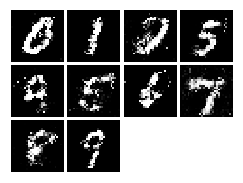


Iter: 3250, D: 1.372, G:0.8699
Iter: 3300, D: 1.379, G:0.7728
Iter: 3350, D: 1.272, G:0.8923
Iter: 3400, D: 1.33, G:0.8416
Iter: 3450, D: 1.285, G:0.816


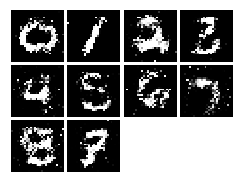


Iter: 3500, D: 1.379, G:0.8089
Iter: 3550, D: 1.303, G:0.8155
Iter: 3600, D: 1.305, G:0.7861
Iter: 3650, D: 1.303, G:0.9158
Iter: 3700, D: 1.315, G:0.8639


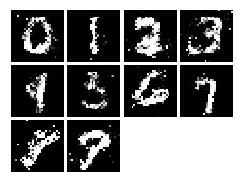


Iter: 3750, D: 1.359, G:0.6883
Iter: 3800, D: 1.303, G:0.8309
Iter: 3850, D: 1.398, G:0.8165
Iter: 3900, D: 1.324, G:0.8108
Iter: 3950, D: 1.317, G:0.7955


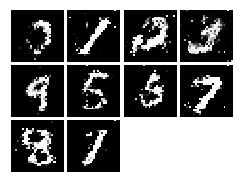


Iter: 4000, D: 1.283, G:0.8617
Iter: 4050, D: 1.346, G:0.7932
Iter: 4100, D: 1.338, G:0.809
Iter: 4150, D: 1.367, G:0.7072
Iter: 4200, D: 1.339, G:0.8097


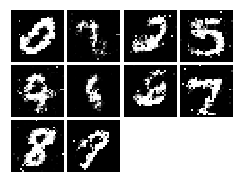


Iter: 4250, D: 1.324, G:0.7427
Iter: 4300, D: 1.368, G:0.8224
Iter: 4350, D: 1.321, G:0.8362
Iter: 4400, D: 1.298, G:0.7573
Iter: 4450, D: 1.381, G:0.7876


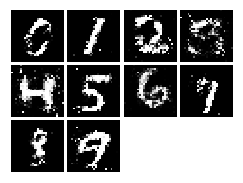


Iter: 4500, D: 1.385, G:0.7661
Iter: 4550, D: 1.337, G:0.8172
Iter: 4600, D: 1.354, G:0.723
Iter: 4650, D: 1.38, G:0.8272
Iter: 4700, D: 1.311, G:0.816


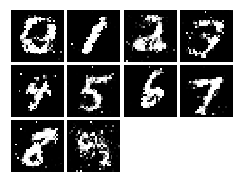


Iter: 4750, D: 1.276, G:0.8239
Iter: 4800, D: 1.317, G:0.7915
Iter: 4850, D: 1.409, G:0.7882
Iter: 4900, D: 1.371, G:0.7846
Iter: 4950, D: 1.33, G:0.8106


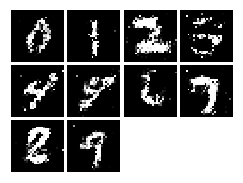


Iter: 5000, D: 1.382, G:0.77
Iter: 5050, D: 1.324, G:0.7918
Iter: 5100, D: 1.319, G:0.805
Iter: 5150, D: 1.294, G:0.8449
Iter: 5200, D: 1.378, G:0.8228


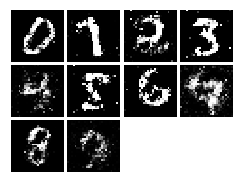


Iter: 5250, D: 1.336, G:0.7592
Iter: 5300, D: 1.347, G:0.7651
Iter: 5350, D: 1.389, G:0.7715
Iter: 5400, D: 1.414, G:0.8095
Iter: 5450, D: 1.355, G:0.8411


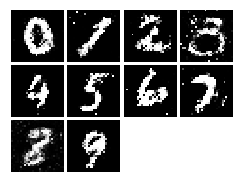


Iter: 5500, D: 1.336, G:0.8813
Iter: 5550, D: 1.394, G:0.9493
Iter: 5600, D: 1.329, G:0.7616
Iter: 5650, D: 1.333, G:0.7727
Iter: 5700, D: 1.318, G:0.7678


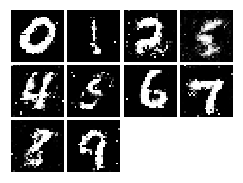


Iter: 5750, D: 1.384, G:0.8545
Iter: 5800, D: 1.346, G:0.8098
Iter: 5850, D: 1.337, G:0.7468
Iter: 5900, D: 1.339, G:0.7986
Iter: 5950, D: 1.351, G:0.8272


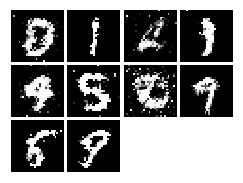


Iter: 6000, D: 1.323, G:0.7855
Iter: 6050, D: 1.364, G:0.7708
Iter: 6100, D: 1.351, G:0.7496
Iter: 6150, D: 1.348, G:0.7799
Iter: 6200, D: 1.345, G:0.8011


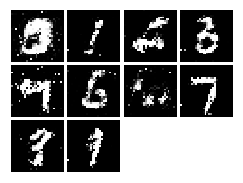


Iter: 6250, D: 1.316, G:0.7953
Iter: 6300, D: 1.286, G:0.7599
Iter: 6350, D: 1.322, G:0.776
Iter: 6400, D: 1.325, G:0.8146
Iter: 6450, D: 1.336, G:0.7615


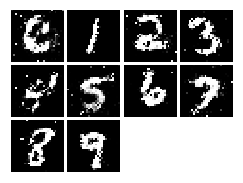


Iter: 6500, D: 1.334, G:0.7794
Iter: 6550, D: 1.409, G:0.741
Iter: 6600, D: 1.387, G:0.7939
Iter: 6650, D: 1.342, G:0.7868
Iter: 6700, D: 1.314, G:0.7811


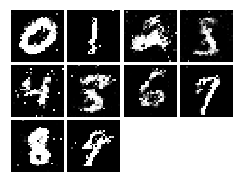


Iter: 6750, D: 1.351, G:0.8198
Iter: 6800, D: 1.408, G:0.8193
Iter: 6850, D: 1.365, G:0.7602
Iter: 6900, D: 1.388, G:0.8083
Iter: 6950, D: 1.325, G:0.7762


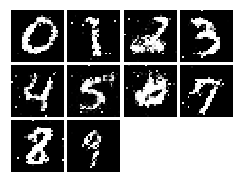


Iter: 7000, D: 1.326, G:0.7679
Iter: 7050, D: 1.315, G:0.7946
Iter: 7100, D: 1.289, G:0.9019
Iter: 7150, D: 1.334, G:0.7671
Iter: 7200, D: 1.355, G:0.7034


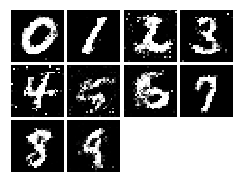


Iter: 7250, D: 1.34, G:0.8544
Iter: 7300, D: 1.327, G:0.7623
Iter: 7350, D: 1.276, G:0.7833
Iter: 7400, D: 1.346, G:0.9031
Iter: 7450, D: 1.344, G:0.8581


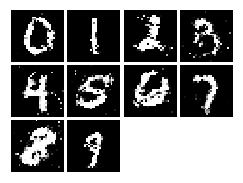


Iter: 7500, D: 1.366, G:0.8652
Iter: 7550, D: 1.298, G:0.8142
Iter: 7600, D: 1.34, G:0.7531
Iter: 7650, D: 1.311, G:0.7095
Iter: 7700, D: 1.362, G:0.7681


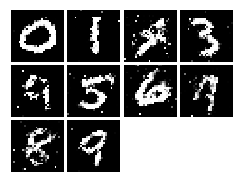


Iter: 7750, D: 1.289, G:0.7852
Iter: 7800, D: 1.37, G:0.8257
Iter: 7850, D: 1.336, G:0.8079
Iter: 7900, D: 1.374, G:0.8331
Iter: 7950, D: 1.38, G:0.8526


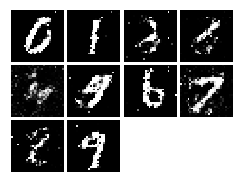


Iter: 8000, D: 1.34, G:0.798
Iter: 8050, D: 1.341, G:0.7816
Iter: 8100, D: 1.381, G:0.7942
Iter: 8150, D: 1.285, G:0.8739
Iter: 8200, D: 1.349, G:0.782


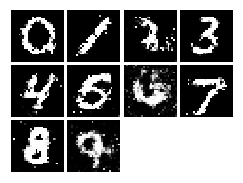


Iter: 8250, D: 1.405, G:0.7778
Iter: 8300, D: 1.277, G:0.8958
Iter: 8350, D: 1.297, G:0.8539
Iter: 8400, D: 1.27, G:0.7919
Iter: 8450, D: 1.313, G:0.7314


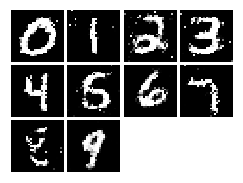


Iter: 8500, D: 1.492, G:0.7456
Iter: 8550, D: 1.402, G:0.7844
Final images


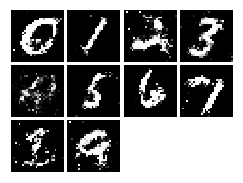

In [23]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    p = run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss, num_epoch=20)
    

INFO:tensorflow:Restoring parameters from C:/Users/공관/ml/assignment3/tmp/my_model.ckpt-8593


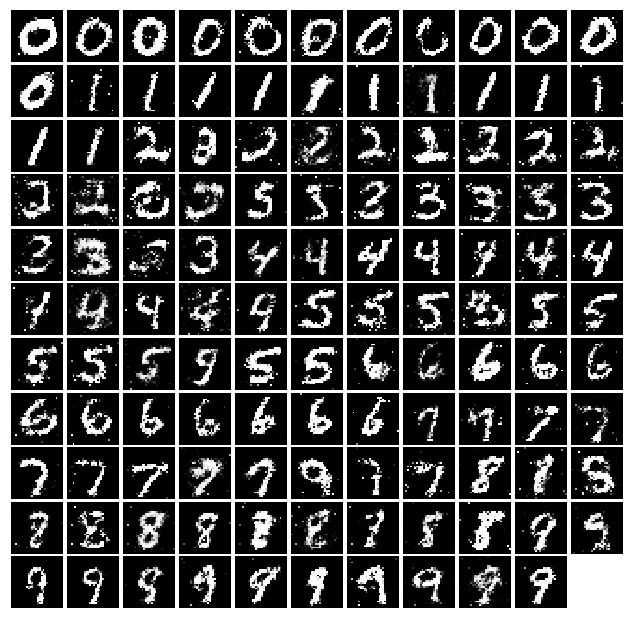

In [36]:
saver = tf.train.Saver()

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
test_y = []
for i in range(10):
    test_y += [i]*12
test_y += [0]*8

with tf.Session() as sess:
  # Restore variables from disk.
    saver.restore(sess, p)
    samples = sess.run(G_sample, feed_dict={y:sess.run(tf.one_hot(test_y, 10))})

    fig = show_images(samples[:120])
    plt.show()

# WGAN-GP (Small Extra Credit)

Please only attempt after you have completed everything above.

We'll now look at [Improved Wasserstein GAN](https://arxiv.org/abs/1704.00028) as a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement Algorithm 1 in the paper. 

You'll also need to use a discriminator and corresponding generator without max-pooling. So we cannot use the one we currently have from DCGAN. Pair the DCGAN Generator (from InfoGAN) with the discriminator from [InfoGAN](https://arxiv.org/pdf/1606.03657.pdf) Appendix C.1 MNIST (We don't use Q, simply implement the network up to D). You're also welcome to define a new generator and discriminator in this notebook, in case you want to use the fully-connected pair of D(x) and G(z) you used at the top of this notebook.

Architecture:
* 64 Filters of 4x4, stride 2, LeakyReLU
* 128 Filters of 4x4, stride 2, LeakyReLU
* BatchNorm
* Flatten
* Fully connected 1024, LeakyReLU
* Fully connected size 1

In [20]:
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        dense1 = tf.layers.dense(z, 1024, activation=tf.nn.relu)
        bn1 = tf.layers.batch_normalization(dense1, training=True)
        dense2 = tf.layers.dense(bn1, 7*7*128, activation=tf.nn.relu)
        bn2 = tf.layers.batch_normalization(dense2, training=True)
        img_reshaped = tf.reshape(bn2, [-1, 7, 7, 128])
        trans_conv1 = tf.layers.conv2d_transpose(img_reshaped, 64, 4, 2, activation=tf.nn.relu, padding='same')
        bn3 = tf.layers.batch_normalization(trans_conv1, training=True)
        trans_conv2 = tf.layers.conv2d_transpose(bn3, 1, 4, 2, activation=tf.nn.tanh, padding='same')
        img = tf.reshape(trans_conv2, [-1, 784])
        return img

def discriminator(x):
    with tf.variable_scope('discriminator'):
        x_reshaped = tf.reshape(x, shape=[-1, 28, 28, 1])
        conv1 = tf.layers.conv2d(x_reshaped, 64, 4, 2, activation=leaky_relu)
        conv2 = tf.layers.conv2d(conv1, 128, 4, 2, activation=leaky_relu)
        bn1 = tf.layers.batch_normalization(conv2, training=True)
        flat = tf.layers.flatten(bn1)
        dense1 = tf.layers.dense(flat, 1024, activation=leaky_relu)
        logits = tf.layers.dense(dense1, 1)
        return logits

test_discriminator(3411649)

Correct number of parameters in discriminator.


In [21]:
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator')

D_solver, G_solver = get_solvers()

In [22]:
def wgangp_loss(logits_real, logits_fake, batch_size, x, G_sample):
    """Compute the WGAN-GP loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    - batch_size: The number of examples in this batch
    - x: the input (real) images for this batch
    - G_sample: the generated (fake) images for this batch
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = tf.reduce_mean(logits_fake) - tf.reduce_mean(logits_real)
    G_loss = -tf.reduce_mean(logits_fake)

    # lambda from the paper
    lam = 10
    
    # random sample of batch_size (tf.random_uniform)
    eps = tf.random_uniform([batch_size, 1], minval=0.0, maxval=1.0)
    x_hat = eps * x + (1 - eps) * G_sample

    # Gradients of Gradients is kind of tricky!
    with tf.variable_scope('',reuse=True) as scope:
        grad_D_x_hat = tf.gradients(discriminator(x_hat), x_hat)

    grad_norm = tf.norm(grad_D_x_hat[0], axis=1, ord='euclidean')
    grad_pen = lam * tf.reduce_mean(tf.square(grad_norm - 1))
    D_loss += grad_pen


    return D_loss, G_loss

D_loss, G_loss = wgangp_loss(logits_real, logits_fake, 128, x, G_sample)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')



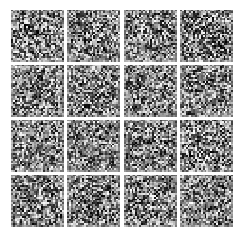


Iter: 0, D: 12.42, G:0.4046
Iter: 50, D: -2.384, G:-2.459
Iter: 100, D: -2.409, G:-3.133
Iter: 150, D: 0.3107, G:-0.9669
Iter: 200, D: -0.3518, G:-0.8832


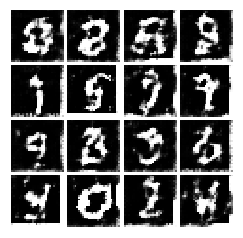


Iter: 250, D: 0.4951, G:-1.397
Iter: 300, D: 0.5013, G:-3.058
Iter: 350, D: -0.3348, G:1.906
Iter: 400, D: -0.6008, G:-0.644
Iter: 450, D: -0.4485, G:-3.099


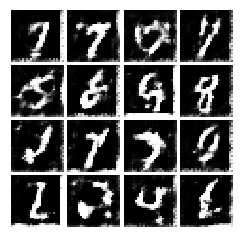


Iter: 500, D: -0.4007, G:-1.468
Iter: 550, D: -0.672, G:-4.116
Iter: 600, D: -0.8148, G:-3.505
Iter: 650, D: -0.6238, G:-2.108
Iter: 700, D: -0.324, G:0.1526


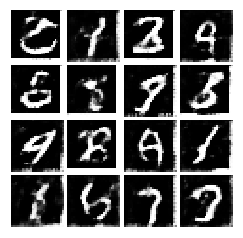


Iter: 750, D: -0.5247, G:-4.929
Iter: 800, D: -0.3961, G:-3.076
Iter: 850, D: -1.038, G:-4.824
Iter: 900, D: -0.7943, G:-2.073
Iter: 950, D: -1.39, G:-3.509


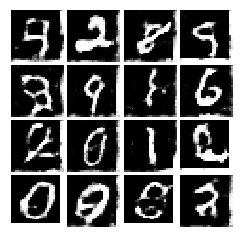


Iter: 1000, D: 0.2882, G:-0.9363
Iter: 1050, D: -1.772, G:-6.724
Iter: 1100, D: -1.374, G:-4.357
Iter: 1150, D: -1.369, G:-4.138
Iter: 1200, D: -2.525, G:-8.996


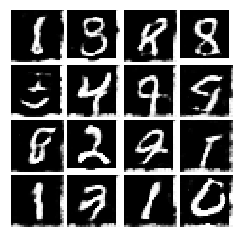


Iter: 1250, D: -0.6387, G:-7.817
Iter: 1300, D: -1.813, G:-6.227
Iter: 1350, D: -1.576, G:-7.718
Iter: 1400, D: -1.371, G:-8.399
Iter: 1450, D: -1.942, G:-9.152


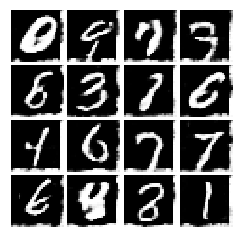


Iter: 1500, D: -2.008, G:-8.67
Iter: 1550, D: -0.3424, G:-6.288
Iter: 1600, D: -0.7477, G:-8.544
Iter: 1650, D: -1.406, G:-3.906
Iter: 1700, D: -2.493, G:-8.499


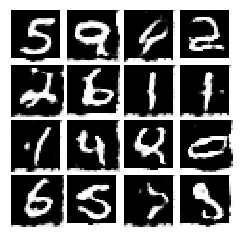


Iter: 1750, D: -2.441, G:-9.881
Iter: 1800, D: 0.2323, G:1.038
Iter: 1850, D: 0.932, G:0.6037
Iter: 1900, D: 0.08241, G:1.107
Iter: 1950, D: -0.4783, G:1.522


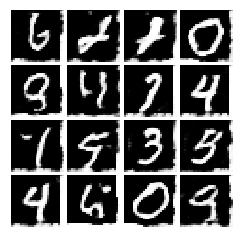


Iter: 2000, D: -0.08555, G:-1.189
Iter: 2050, D: -0.2134, G:-0.496
Iter: 2100, D: 0.6227, G:0.1216
Final images


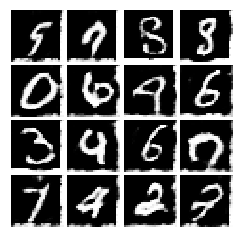

In [23]:
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss, G_extra_step, D_extra_step, batch_size=128,num_epoch=5)